# #01a - TEDA-Forecasting on WandB

## 1. Modules import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from random import randint, sample

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from codecarbon import EmissionsTracker

#### Importing our modules:

In [2]:
from teda import TEDA
from RLSFilter import RLSFilter

from treating import dataTreating, dataSpliting, dataProcessing, dataSplit

In [3]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

## 2. Data managing

### 2.1 Power data:

In [4]:
data = pd.read_csv("Electric_Production.csv")
data.rename(columns={'DATE':'Date', 'IPG2211A2N':'Production'}, inplace=True)
data.head()

#Variables
series = "Production"
date = "Date"

### 2.2 Inserting outliers:

In [5]:
data['label'] = 0

In [6]:
outliers_percentage = 8/100

#Outliers do tipo zero
#z = o[0:np.round(len(o)/2).astype(int)]
z = [61,37,287,230,214,162,98,30,278,28,25,314,348,195,113,387]

#Outliers do tipo pico
#p = o[np.round(len(o)/2).astype(int): -1]
p = [125,242,291,377,34,206,249,118,389,12,376,375,74,146,272,368]

#### Peak-type outliers will have **twice** the magnitude. Therefore:

In [7]:
data['Outlier'] = data[series]

data['Outlier'].iloc[p] = 1.5*data[series].iloc[p]
data['label'].iloc[p] = 1

c:\Users\Samsung\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


#### Zero-type outliers has value equals **zero**:

In [8]:
data['Outlier'].iloc[z] = 0
data['label'].iloc[z] = 1

### Let's see the new curve:

In [9]:
figure = make_subplots(specs=[[{"secondary_y": True}]])

figure.update_layout(
    title="Dataset with outliers"
)

figure.add_trace(
    go.Scatter(y=data['Outlier'], name='With Outliers'),
    secondary_y=False
)

figure.update_xaxes(title='Time (months)')
figure.update_yaxes(title='Eletric Production', secondary_y=False)
figure.show()

## 3. WandB

### 3.1 WandB importing

In [ ]:
#!pip install wandb

In [ ]:
import os
import wandb
import logging

In [ ]:
os.environ["WANDB__SERVICE_WAIT"] = "100000000"

In [ ]:
!wandb login 40f0acf51f839c9bfbed5c1f24e945ed8245e110

### 3.2 Initialize a new W&B run to track this job

In [ ]:
run = wandb.init(project="TEDARegressor", job_type="dataset-creation")

In [ ]:
# Create a new artifact, which is a sample dataset
dataset = wandb.Artifact('Electric_Production.csv', type='dataset')
# Add files to the artifact, in this case a simple text file
dataset.add_file('Electric_Production.csv')
# Log the artifact to save it as an output of this run
run.log_artifact(dataset)

### 3.3 Configure logging:

In [ ]:
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

### 3.4 Defining dictionaries:

#### 3.4.1 Metrics dictionary:

In [ ]:
metric_dict = {
    'name': 'rmse_pred',
    'goal': 'minimize'   
    }

#### 3.4.2 Parameters dictionary:

In [ ]:
parameters_dict = {
    #TEDA Forecasting
    'Threshold': {
          'values': [1.2, 2, 2.5]
        },
    'FlagCorrection': {
          'values': [True, False]
        },
    'N_outlier_max': {
          'values': [1,2,3]
        },   
    'FilterOrder': {
      'values': [2,3,4]
    },
    'Forecasting': {
      'values': [2,3,4]
    },    
    'Forgetting': {
          'values': [0.95, 0.99, 1]
        },    
    'Regularization': {
          'values': [0.1, 1]         
        },
}

### 3.5 Defining Sweep

In [ ]:
seed = 41
sweep_config = {
    "method": "grid", ## Bayesian search => atraves de modelo probabilístico
    "metric": metric_dict,
    "parameters": parameters_dict,

}
sweep_id = wandb.sweep(sweep_config, project="TEDARegressor")

### 3.6 Training

In [ ]:
def train():
    with wandb.init() as run:
        RMSE_full = []
        MAE_full = []

        window = wandb.config.FilterOrder
        forecasting = wandb.config.Forecasting

        # Data processing
        df, df_train, df_test, X_train, y_train, X_test, y_test = dataSplit(data["Outlier"], data["label"], window=window, forecasting=forecasting, N_splits=4)

        # Labels Index
        labelsIndex = find_indices(df_test['label'], 1)
        ts = np.linspace(0, len(df_test), len(df_test))

        #TEDA
        teda = TEDA(threshold=wandb.config.Threshold)
        N_outlier_max = wandb.config.N_outlier_max    # Consecutive outlier correction flagN_outlier_max   # Maximum of outliers corrected by TEDAForecasting
        correction = wandb.config.FlagCorrection    # Consecutive outlier correction flag

        FLAG = []

        #RLS
        filter_order = window                           # Filter_order equivalent to window size
        w0 = np.zeros(filter_order).tolist()            # Initial weights
        X_ant = np.zeros(filter_order).tolist()         # Initial previous input
        rls_filter = RLSFilter(n = window, mu = wandb.config.Forgetting, delta=wandb.config.Regularization, w=w0) #Defining the filter instance

        Ya_py = []          # Vector of auxiliary predicted values
        Y_py = []           # Vector of predicted values
        Y_v = []            # Vector of virtual predicted values
        DB = []             # Vector of saved values (database)
        outlier_count = 0   # Outlier count 
        y_pred_py = 0.0     # Initial predicted value

        # create codecarbon tracker
        # codecarbon is too much verbose, change the log level for more info
        tracker = EmissionsTracker(log_level="critical")
        tracker.start()        

        for i in df_test['x(t)']:
            ## Acquiring the data input
            valor_atual = i

            #Checking if it is an outlier
            flag = teda.run(valor_atual)
            FLAG.append(flag)

            ## First Stage: Correcting outlier
            if (flag == 1):       
                outlier_count = outlier_count + 1
                valor_atual = y_pred_py
            else:
                outlier_count = 0
            
            #Evaluating the flood of outliers
            if(correction == True and outlier_count == N_outlier_max + 1):
                valor_atual = i
            
            #Saving 
            Ya_py.append(y_pred_py)

            # Updating weights
            rls_filter.update(valor_atual, np.array(X_ant))

            input_vector = []
            for j in X_ant[1:]:
                input_vector.append(j)
            input_vector.append(valor_atual)

            #Predicting the next value
            y_pred_py = rls_filter.filter(input_vector)
            Y_py.append(y_pred_py)

            # Creating virtual inputs
            virtual_input = input_vector[1:]
            virtual_input.append(y_pred_py)

            # Creating virtual filter
            w_virtual = []
            for x in rls_filter.w:
                w_virtual.append(x)
            virtual_filter = RLSFilter(n = filter_order, mu = wandb.config.Forgetting, delta=wandb.config.Regularization, w=w_virtual) #Defining the filter instance
            virtual_filter.update(y_pred_py, np.array(input_vector))


            for l in range(1, forecasting):
                #Predicting the next value
                y_pred_virtual = virtual_filter.filter(virtual_input)
                virtual_filter.update(y_pred_virtual, np.array(virtual_input))
                Y_v.append(y_pred_virtual)

                virtual_input = virtual_input[1:]
                virtual_input.append(y_pred_virtual)
            
            # Second stage
            if (flag == 1):
                valor_atual = y_pred_py

            if(correction == True and outlier_count == N_outlier_max + 1):
                outlier_count = 0
                valor_atual = i
            DB.append(valor_atual)

            #Updating previous values vector
            X_ant = input_vector

        # get co2 emissions from tracker
        # "CO2 emission (in Kg)"
        emissions = tracker.stop()
        # energy unit is kWh
        run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
        #run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
        #run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
        #run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
        # kg
        #run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

        df_test['flag_py'] = FLAG
        df_test['save_py'] = DB
        df_test['ya_pred_py'] = Ya_py
        df_test['y_pred_py'] = Y_py

        ### Creating the forecasting dataframe:
        Y_v = np.array(Y_v).reshape(len(df_test),(forecasting-1))

        df_y_forecasting_columns = []
        for i in range(1, forecasting+1):
            df_y_forecasting_columns.append('y(t+' + str(i) + ')')

        df_Y_v = pd.DataFrame(data=Y_v)
        df_Y_v.insert(loc=0, column=df_y_forecasting_columns[0], value=Y_py, allow_duplicates=True)
        df_Y_v.set_axis(df_y_forecasting_columns, axis=1, inplace=True)

        numberOfOutliersPython = df_test['flag_py'].sum()
        outliersIndexPython = find_indices(df_test['flag_py'], 1)

        # TEDA Metrics:
        f1 = f1_score(df_test['label'], df_test['flag_py'])
        accuracy = accuracy_score(df_test['label'], df_test['flag_py'])
        recall = recall_score(df_test['label'], df_test['flag_py'])
        # Logging
        run.summary['f1_score'] = f1
        wandb.log({"f1_score": f1})
        run.summary['accuracy'] = accuracy
        wandb.log({"accuracy": accuracy})
        run.summary['recall'] = recall
        wandb.log({"recall": recall})


        # Forecasting
        RMSE = []
        for i in range(0, forecasting):
            rmse = mean_squared_error(y_test[0:-1, i], df_Y_v.iloc[1:, i].values, squared=False)
            RMSE.append(rmse)
        rmse_pred = mean_squared_error(y_test[0:-1, 0], df_Y_v.iloc[1:, 0].values, squared=False)
        RMSE_full.append(RMSE)
        RMSE_mean = np.mean(RMSE)
        RMSE_max = np.max(RMSE)
        RMSE_min = np.min(RMSE)
        RMSE_std = np.std(RMSE)

        # Logging
        # RMSE
        ## Pred
        run.summary['rmse_pred'] = rmse_pred
        wandb.log({"rmse_pred": rmse_pred})
        ## Mean
        run.summary['rmse_mean'] = RMSE_mean
        wandb.log({"rmse_mean": RMSE_mean})
        ## Max     
        run.summary['rmse_max'] = RMSE_max
        wandb.log({"rmse_max": RMSE_max})
        ## Min
        run.summary['rmse_min'] = RMSE_min
        wandb.log({"rmse_min": RMSE_min})
        ## Std
        #run.summary['rmse_std'] = RMSE_std
        #wandb.log({"rmse_std": RMSE_std})

        MAE = []
        for i in range(0, forecasting):
            mae = mean_absolute_error(y_test[0:-1, i], df_Y_v.iloc[1:, i].values)
            MAE.append(mae)
        mae_pred = mean_absolute_error(y_test[0:-1, 0], df_Y_v.iloc[1:, 0].values)
        MAE_full.append(MAE)
        MAE_mean = np.mean(MAE)
        MAE_max = np.max(MAE)
        MAE_min = np.min(MAE)
        MAE_std = np.std(MAE)

        # Logging
        # MAE
        ## Pred
        run.summary['mae_pred'] = mae_pred
        wandb.log({"mae_pred": mae_pred})
        ## Mean
        run.summary['mae_mean'] = MAE_mean
        wandb.log({"mae_mean": MAE_mean})
        ## Max     
        run.summary['mae_max'] = MAE_max
        wandb.log({"mae_max": MAE_max})
        ## Min
        run.summary['mae_min'] = MAE_min
        wandb.log({"mae_min": MAE_min})
        ## Std
        #run.summary['mae_std'] = MAE_std
        #wandb.log({"mae_std": MAE_std})
    #run.finish()


In [ ]:
wandb.agent(sweep_id, train)

# 4. Sweep Analysis

## 4.1 Visualization

Here, we can visualize the Sweep Results 👀. We have use the **Parallel Coordinates Plot 🔀** to map hyperparameter values to model metrics.
We've used to see the combinations of hyperparameters that led to the **best model performance 📊**:


#### Sweep Eletric Production Data

![Sweep Power Data](sweeps/teda_forecasting_sweep_figure.png)

#### Now, we are going to look the model results:

In [2]:
df_sweep = pd.read_csv("sweeps/teda_forecasting_sweep_table.csv")

## 4.2 TEDA Metrics

#### To analyze TEDA, we must evaluate the classification metrics (accuracy, f1 score, and recall) for each sensitivity threshold of the algorithm.

#### Accuracy:

In [3]:
min_acc_1_2 = df_sweep[df_sweep['Threshold']==1.2].min()['accuracy']
min_acc_2 = df_sweep[df_sweep['Threshold']==2].min()['accuracy']
min_acc_2_5 = df_sweep[df_sweep['Threshold']==2.5].min()['accuracy']

#### *f1* score

In [4]:
min_f1score_1_2 = df_sweep[df_sweep['Threshold']==1.2].min()['f1_score']
min_f1score_2 = df_sweep[df_sweep['Threshold']==2].min()['f1_score']
min_f1score_2_5 = df_sweep[df_sweep['Threshold']==2.5].min()['f1_score']

#### Recall:

In [5]:
min_recall_1_2 = df_sweep[df_sweep['Threshold']==1.2].min()['recall']
min_recall_2 = df_sweep[df_sweep['Threshold']==2].min()['recall']
min_recall_2_5 = df_sweep[df_sweep['Threshold']==2.5].min()['recall']

In [6]:
threshold_label = ["1.2", "2.0", "2.5"]
results_acc = [min_acc_1_2, min_acc_2, min_acc_2_5]
results_f1score = [min_f1score_1_2, min_f1score_2, min_f1score_2_5]
results_recall = [min_recall_1_2, min_recall_2, min_recall_2_5]
df_teda_results = pd.DataFrame(data={"Threshold": threshold_label, "Accuracy": results_acc, "Recall": results_recall, "f1 score": results_f1score})
df_teda_results.head()

,Threshold,Accuracy,Recall,f1 score
0,1.2,0.897436,1.000000,0.636364
1,2.0,0.974359,0.714286,0.833333
2,2.5,0.961538,0.571429,0.727273


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


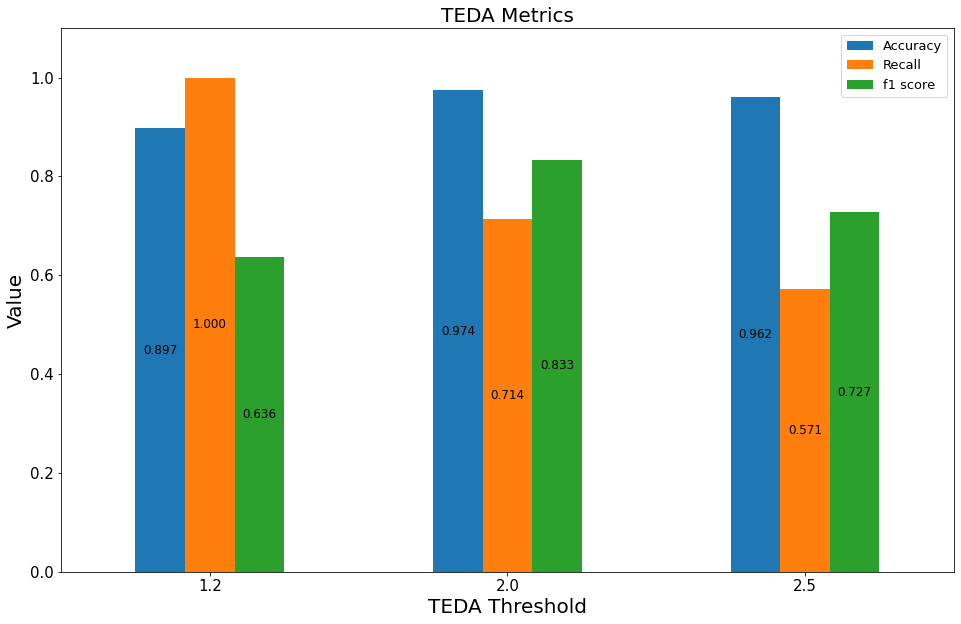

In [9]:
# plot bars or kind='barh' for horizontal bars; adjust figsize accordingly
ax = df_teda_results.plot(kind='bar', rot=0, xlabel='Threshold', ylabel='Recall', figsize=(16, 10))

X_axis = np.arange(len(threshold_label))

# add some labels
for c in ax.containers:
    # set the bar label
    ax.bar_label(c, fmt='%.3f', label_type='center',fontsize=12)
    
# add a little space at the top of the plot for the annotation
ax.margins(y=0.1)

plt.xticks(X_axis, threshold_label) 

# move the legend out of the plot
ax.legend(fontsize=13)

plt.title("TEDA Metrics", fontsize=20)
plt.xlabel("TEDA Threshold", fontsize=20)
plt.ylabel("Value", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.show()

plt.savefig("results_eletric_TEDA_metrics.eps", dpi=600, bbox_inches='tight')
#plt.savefig('', format='png', bbox_inches='tight')

## 4.3 Forecasting

### 4.3.1 Lower RMSE of the predicted value ($RMSE_{pred}$):

In [8]:
df_sweep[df_sweep['rmse_pred']==df_sweep['rmse_pred'].min()]

,Name,Threshold,FlagCorrection,N_outlier_max,FilterOrder,Forecasting,Forgetting,Regularization,Energy_Consumed,accuracy,f1_score,recall,mae_pred,mae_max,mae_mean,mae_min,rmse_pred,rmse_max,rmse_mean,rmse_min
221,peach-sweep-757,1.2,True,1,4,4,0.95,0.1,4.679354e-08,0.910256,0.666667,1.0,5.308628,23.420714,16.63656,5.308628,15.571152,32.071617,26.116015,15.571152


### 4.3.2 Lower MAE of the predicted value ($MAE_{pred}$):

In [9]:
df_sweep[df_sweep['mae_pred']==df_sweep['mae_pred'].min()]

,Name,Threshold,FlagCorrection,N_outlier_max,FilterOrder,Forecasting,Forgetting,Regularization,Energy_Consumed,accuracy,f1_score,recall,mae_pred,mae_max,mae_mean,mae_min,rmse_pred,rmse_max,rmse_mean,rmse_min
649,robust-sweep-162,2.5,True,3,2,4,1.0,1.0,4.293444e-08,0.961538,0.727273,0.571429,4.354563,22.434481,14.991766,4.354563,18.203841,29.823002,24.201453,18.203841
737,royal-sweep-150,2.5,True,1,2,4,1.0,1.0,4.288938e-08,0.961538,0.727273,0.571429,4.354563,22.434481,14.991766,4.354563,18.203841,29.823002,24.201453,18.203841
749,astral-sweep-324,2.5,False,3,2,4,1.0,1.0,4.505187e-08,0.961538,0.727273,0.571429,4.354563,22.434481,14.991766,4.354563,18.203841,29.823002,24.201453,18.203841
808,ancient-sweep-318,2.5,False,2,2,4,1.0,1.0,4.767307e-08,0.961538,0.727273,0.571429,4.354563,22.434481,14.991766,4.354563,18.203841,29.823002,24.201453,18.203841
929,misty-sweep-312,2.5,False,1,2,4,1.0,1.0,4.024975e-08,0.961538,0.727273,0.571429,4.354563,22.434481,14.991766,4.354563,18.203841,29.823002,24.201453,18.203841
969,fluent-sweep-156,2.5,True,2,2,4,1.0,1.0,4.301532e-08,0.961538,0.727273,0.571429,4.354563,22.434481,14.991766,4.354563,18.203841,29.823002,24.201453,18.203841


# 5. References

 [[1]](https://www.mdpi.com/1424-8220/22/10/3838) **Andrade, P.**; Silva, I.; Silva, M.; Flores, T.; Cassiano, J.; Costa, D.G. *A TinyML Soft-Sensor Approach for Low-Cost Detection and Monitoring of Vehicular Emissions*. SENSORS 2022, 22, 3838.  ![GitHub](https://img.shields.io/badge/DOI-10.3390%2Fs22103838-green)


[[2]](https://dl.acm.org/journal/tecs) **Andrade, P.**; Silva, I.; Silva, M.; Flores, T.; Costa, D.G. Soares, E.; _Online Processing of Vehicular Data on the Edge Through an Unsupervised TinyML Regression Technique_. ACM TECS 2023. ![GitHub](https://img.shields.io/badge/DOI-10.1145%2Fs3591356-green)